In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
import lightgbm as lgb

In [3]:
pd.options.display.max_columns = None   # display all columns
pd.options.display.max_rows = None  # display all rows
pd.options.display.float_format = '{:.6f}'.format   # display float values upto 6 decimal places

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
meal_info = pd.read_csv("meal_info.csv")
fc_info = pd.read_csv("fulfilment_center_info.csv")

## Examine dataset

In [39]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  

(None, None)

In [40]:
meal_info.info(), fc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


(None, None)

In [41]:
train.isnull().sum(), test.isnull().sum()

(id                       0
 week                     0
 center_id                0
 meal_id                  0
 checkout_price           0
 base_price               0
 emailer_for_promotion    0
 homepage_featured        0
 num_orders               0
 dtype: int64, id                       0
 week                     0
 center_id                0
 meal_id                  0
 checkout_price           0
 base_price               0
 emailer_for_promotion    0
 homepage_featured        0
 dtype: int64)

In [42]:
meal_info.isnull().sum(), fc_info.isnull().sum()

(meal_id     0
 category    0
 cuisine     0
 dtype: int64, center_id      0
 city_code      0
 region_code    0
 center_type    0
 op_area        0
 dtype: int64)

In [43]:
train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1250096.305633,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.109200,261.872760
std,144354.822378,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.311890,395.922798
min,1000000.000000,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,13.000000
25%,1124998.750000,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.000000,54.000000
50%,1250183.500000,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.000000,136.000000
75%,1375140.250000,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.000000,324.000000
max,1499999.000000,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.000000,24299.000000


In [49]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.830000,152.290000,0,0,177
1,1466964,1,55,1993,136.830000,135.830000,0,0,270
2,1346989,1,55,2539,134.860000,135.860000,0,0,189
3,1338232,1,55,2139,339.500000,437.530000,0,0,54
4,1448490,1,55,2631,243.500000,242.500000,0,0,40


In [57]:
train.shape

(456548, 9)

## Data cleaning

In [12]:
train_df = pd.merge(train, meal_info, on="meal_id", how="left")
train_df = pd.merge(train_df, fc_info, on="center_id", how="left")
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


**Features**

week -> Numerical
checkout_price -> Numerical
base_price -> Numerical
emailer_for_promotion -> Categorical	
homepage_featured -> Categorical	
num_orders -> Numerical
category -> Categorical	
cuisine -> Categorical		
city_code -> Categorical	
region_code -> Categorical		
center_type -> Categorical	
op_area -> Numerical

**FE**

discount = base_price - checkout_price

In [12]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.830000,152.290000,0,0,177
1,1466964,1,55,1993,136.830000,135.830000,0,0,270
2,1346989,1,55,2539,134.860000,135.860000,0,0,189
3,1338232,1,55,2139,339.500000,437.530000,0,0,54
4,1448490,1,55,2631,243.500000,242.500000,0,0,40


In [13]:
train_df = train_df.drop(["id", "emailer_for_promotion", "homepage_featured"], axis=1)

In [10]:
train_df.shape

(456548, 9)

In [87]:
print(len(train_df['city_code'].unique()))
print(len(train_df['region_code'].unique()))
print(len(train_df['category'].unique()))
print(len(train_df['cuisine'].unique()))
print(len(train_df['center_type'].unique()))
#print(len(train_df['center_id'].unique()))
#print(len(train_df['meal_id'].unique()))            

51
8
14
4
3


In [5]:
train_df = train_df.drop(['id', 'center_id', 'meal_id'], axis=1)
train_df.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              456548 non-null  int64  
 1   week            456548 non-null  int64  
 2   center_id       456548 non-null  int64  
 3   meal_id         456548 non-null  int64  
 4   checkout_price  456548 non-null  float64
 5   base_price      456548 non-null  float64
 6   num_orders      456548 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 24.4 MB


In [6]:
#train_df['emailer_for_promotion'] = train_df['emailer_for_promotion'].astype(object)
#train_df['homepage_featured'] = train_df['homepage_featured'].astype(object)
train_df['city_code'] = train_df['city_code'].astype(object)
train_df['region_code'] = train_df['region_code'].astype(object)

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   checkout_price         456548 non-null  float64
 2   base_price             456548 non-null  float64
 3   emailer_for_promotion  456548 non-null  int64  
 4   homepage_featured      456548 non-null  int64  
 5   num_orders             456548 non-null  int64  
 6   category               456548 non-null  object 
 7   cuisine                456548 non-null  object 
 8   city_code              456548 non-null  object 
 9   region_code            456548 non-null  object 
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 45.3+ MB


##visulaizations

<AxesSubplot:>

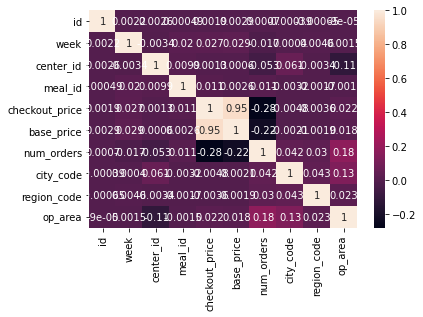

In [31]:
sns.heatmap(train_df.corr(), annot=True)

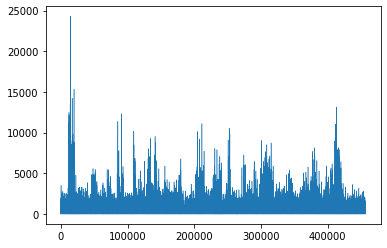

In [75]:
train_df['num_orders'].plot(linewidth=0.5)

In [ ]:
train_df.pivot(index = 'week', columns='')

In [60]:
train_df['week'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145])

## Back to preprocessing

In [15]:
train_df['discount'] = train_df['base_price']-train_df['checkout_price']
train_df = train_df.drop(['base_price'], axis=1)

KeyError: 'base_price'

In [6]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,num_orders,category,cuisine,city_code,region_code,center_type,op_area,discount
0,1379560,1,55,1885,136.83,177,Beverages,Thai,647,56,TYPE_C,2.0,15.46
1,1466964,1,55,1993,136.83,270,Beverages,Thai,647,56,TYPE_C,2.0,-1.00
2,1346989,1,55,2539,134.86,189,Beverages,Thai,647,56,TYPE_C,2.0,1.00
3,1338232,1,55,2139,339.50,54,Beverages,Indian,647,56,TYPE_C,2.0,98.03
4,1448490,1,55,2631,243.50,40,Beverages,Indian,647,56,TYPE_C,2.0,-1.00


In [16]:
train_df = pd.get_dummies(train_df,drop_first=True)

In [35]:
train_df.shape

(456548, 28)

In [17]:
train_split_x = train_df[train_df['week']<=116]
test_split_x = train_df[train_df['week']>116]
train_split_y = train_split_x['num_orders']
test_split_y = test_split_x['num_orders']
train_split_x = train_split_x.drop(['num_orders'], axis=1)
test_split_x = test_split_x.drop(['num_orders'], axis=1)

In [18]:
train_split_x.shape, train_split_y.shape, test_split_x.shape, test_split_y.shape

((361348, 26), (361348,), (95200, 26), (95200,))

In [24]:
train_split_x.columns

Index(['week', 'center_id', 'meal_id', 'checkout_price', 'city_code',
       'region_code', 'op_area', 'discount', 'category_Biryani',
       'category_Desert', 'category_Extras', 'category_Fish',
       'category_Other Snacks', 'category_Pasta', 'category_Pizza',
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Indian', 'cuisine_Italian', 'cuisine_Thai',
       'center_type_TYPE_B', 'center_type_TYPE_C'],
      dtype='object')

In [43]:
temp_row = fc_info[fc_info["center_id"] == 55]
temp_values = temp_row.values.tolist()[0]
temp_values[1:]

[647, 56, 'TYPE_C', 2.0]

In [34]:
print(train_df['center_type'].unique())
print(train_df['category'].unique())
print(train_df['cuisine'].unique())

[2 1 0]
[ 0  8 13  6 10  1  3  7 11  5  2  9  4 12]
[3 1 2 0]


8

In [20]:
train_df.head()

,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,136.830000,152.290000,0,0,177,0,3,647,56,2,2.000000
1,1018704,2,135.830000,152.290000,0,0,323,0,3,647,56,2,2.000000
2,1196273,3,132.920000,133.920000,0,0,96,0,3,647,56,2,2.000000
3,1116527,4,135.860000,134.860000,0,0,163,0,3,647,56,2,2.000000
4,1343872,5,146.500000,147.500000,0,0,215,0,3,647,56,2,2.000000


##Base

XGBoost

In [21]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(train_split_x,train_split_y,        
        eval_set=[(train_split_x,train_split_y), (test_split_x, test_split_y)],)
#        eval_metric='mae')

[0]	validation_0-rmse:479.54755	validation_1-rmse:438.79404
[1]	validation_0-rmse:476.37183	validation_1-rmse:436.40329
[2]	validation_0-rmse:473.22778	validation_1-rmse:434.03918
[3]	validation_0-rmse:470.12802	validation_1-rmse:431.72092
[4]	validation_0-rmse:467.06787	validation_1-rmse:429.44836
[5]	validation_0-rmse:464.05310	validation_1-rmse:427.19516
[6]	validation_0-rmse:461.07095	validation_1-rmse:424.98166
[7]	validation_0-rmse:458.14310	validation_1-rmse:422.66983
[8]	validation_0-rmse:455.23785	validation_1-rmse:420.51654
[9]	validation_0-rmse:452.37824	validation_1-rmse:418.38504
[10]	validation_0-rmse:449.54404	validation_1-rmse:416.22586
[11]	validation_0-rmse:446.75269	validation_1-rmse:414.16190
[12]	validation_0-rmse:443.99301	validation_1-rmse:412.04748
[13]	validation_0-rmse:441.28113	validation_1-rmse:410.04425
[14]	validation_0-rmse:438.59143	validation_1-rmse:408.06805
[15]	validation_0-rmse:435.95422	validation_1-rmse:406.03705
[16]	validation_0-rmse:433.32812	v

[133]	validation_0-rmse:274.04163	validation_1-rmse:282.07739
[134]	validation_0-rmse:273.34161	validation_1-rmse:281.58978
[135]	validation_0-rmse:272.67877	validation_1-rmse:281.14023
[136]	validation_0-rmse:272.02487	validation_1-rmse:280.62317
[137]	validation_0-rmse:271.56467	validation_1-rmse:280.22330
[138]	validation_0-rmse:270.92706	validation_1-rmse:279.72443
[139]	validation_0-rmse:270.36472	validation_1-rmse:279.27664
[140]	validation_0-rmse:269.74063	validation_1-rmse:278.81021
[141]	validation_0-rmse:269.12763	validation_1-rmse:278.29114
[142]	validation_0-rmse:268.49548	validation_1-rmse:277.79336
[143]	validation_0-rmse:267.93692	validation_1-rmse:277.39548
[144]	validation_0-rmse:267.33578	validation_1-rmse:276.95035
[145]	validation_0-rmse:266.75037	validation_1-rmse:276.46609
[146]	validation_0-rmse:266.17471	validation_1-rmse:275.99063
[147]	validation_0-rmse:265.64404	validation_1-rmse:275.61487
[148]	validation_0-rmse:265.08270	validation_1-rmse:275.13831
[149]	va

[266]	validation_0-rmse:229.64835	validation_1-rmse:245.36923
[267]	validation_0-rmse:229.46725	validation_1-rmse:245.25128
[268]	validation_0-rmse:229.33617	validation_1-rmse:245.11621
[269]	validation_0-rmse:229.20775	validation_1-rmse:244.97980
[270]	validation_0-rmse:229.06877	validation_1-rmse:244.87181
[271]	validation_0-rmse:228.85721	validation_1-rmse:244.74795
[272]	validation_0-rmse:228.67660	validation_1-rmse:244.59384
[273]	validation_0-rmse:228.54108	validation_1-rmse:244.45523
[274]	validation_0-rmse:228.33809	validation_1-rmse:244.35941
[275]	validation_0-rmse:228.13353	validation_1-rmse:244.14651
[276]	validation_0-rmse:227.93745	validation_1-rmse:243.98198
[277]	validation_0-rmse:227.75261	validation_1-rmse:243.89172
[278]	validation_0-rmse:227.58160	validation_1-rmse:243.73979
[279]	validation_0-rmse:227.38815	validation_1-rmse:243.54022
[280]	validation_0-rmse:227.22574	validation_1-rmse:243.40460
[281]	validation_0-rmse:227.07469	validation_1-rmse:243.28334
[282]	va

[399]	validation_0-rmse:212.22878	validation_1-rmse:232.62317
[400]	validation_0-rmse:212.11383	validation_1-rmse:232.53548
[401]	validation_0-rmse:212.02432	validation_1-rmse:232.48975
[402]	validation_0-rmse:211.88982	validation_1-rmse:232.40495
[403]	validation_0-rmse:211.77805	validation_1-rmse:232.32088
[404]	validation_0-rmse:211.64653	validation_1-rmse:232.22728
[405]	validation_0-rmse:211.52635	validation_1-rmse:232.15732
[406]	validation_0-rmse:211.44237	validation_1-rmse:232.05261
[407]	validation_0-rmse:211.38001	validation_1-rmse:232.01077
[408]	validation_0-rmse:211.27193	validation_1-rmse:231.97049
[409]	validation_0-rmse:211.17316	validation_1-rmse:231.88258
[410]	validation_0-rmse:211.06523	validation_1-rmse:231.79881
[411]	validation_0-rmse:210.96881	validation_1-rmse:231.70749
[412]	validation_0-rmse:210.86160	validation_1-rmse:231.62608
[413]	validation_0-rmse:210.73469	validation_1-rmse:231.59874
[414]	validation_0-rmse:210.63002	validation_1-rmse:231.56099
[415]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = reg.predict(test_split_x)
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

RMSLE: 75.66849939844735


GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

LightGBM

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(train_split_x,train_split_y,
        eval_set=[(train_split_x,train_split_y), (test_split_x, test_split_y)],
        early_stopping_rounds=1000)

y_pred = gbm.predict(test_split_x)
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

##FE

In [24]:
reg2 = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg2.fit(train_split_x, 
        train_split_y,        
        eval_set=[(train_split_x,train_split_y), (test_split_x, test_split_y)],)
#        eval_metric='mae')

[0]	validation_0-rmse:479.90753	validation_1-rmse:439.22110
[1]	validation_0-rmse:477.08136	validation_1-rmse:437.24368
[2]	validation_0-rmse:474.29392	validation_1-rmse:435.29871
[3]	validation_0-rmse:471.55209	validation_1-rmse:433.38309
[4]	validation_0-rmse:468.84418	validation_1-rmse:431.50278
[5]	validation_0-rmse:466.17007	validation_1-rmse:429.62903
[6]	validation_0-rmse:463.53720	validation_1-rmse:427.80206
[7]	validation_0-rmse:460.94940	validation_1-rmse:426.02911
[8]	validation_0-rmse:458.31720	validation_1-rmse:424.02182
[9]	validation_0-rmse:455.72855	validation_1-rmse:422.04639
[10]	validation_0-rmse:453.25287	validation_1-rmse:420.37399
[11]	validation_0-rmse:450.72876	validation_1-rmse:418.41669
[12]	validation_0-rmse:448.24207	validation_1-rmse:416.52295
[13]	validation_0-rmse:445.86185	validation_1-rmse:414.91235
[14]	validation_0-rmse:443.44705	validation_1-rmse:413.09232
[15]	validation_0-rmse:441.06732	validation_1-rmse:411.27316
[16]	validation_0-rmse:438.71222	v

[134]	validation_0-rmse:304.13992	validation_1-rmse:311.22199
[135]	validation_0-rmse:303.64389	validation_1-rmse:310.85413
[136]	validation_0-rmse:303.14993	validation_1-rmse:310.49448
[137]	validation_0-rmse:302.66385	validation_1-rmse:310.14722
[138]	validation_0-rmse:302.19229	validation_1-rmse:309.84967
[139]	validation_0-rmse:301.65128	validation_1-rmse:309.40930
[140]	validation_0-rmse:301.18829	validation_1-rmse:309.07278
[141]	validation_0-rmse:300.73514	validation_1-rmse:308.78775
[142]	validation_0-rmse:300.27179	validation_1-rmse:308.48984
[143]	validation_0-rmse:299.82562	validation_1-rmse:308.14456
[144]	validation_0-rmse:299.36905	validation_1-rmse:307.85687
[145]	validation_0-rmse:298.97965	validation_1-rmse:307.56775
[146]	validation_0-rmse:298.56436	validation_1-rmse:307.29907
[147]	validation_0-rmse:298.15878	validation_1-rmse:306.99701
[148]	validation_0-rmse:297.78918	validation_1-rmse:306.78021
[149]	validation_0-rmse:297.39249	validation_1-rmse:306.51389
[150]	va

[399]	validation_0-rmse:249.36018	validation_1-rmse:269.18796
[400]	validation_0-rmse:249.23921	validation_1-rmse:269.06720
[401]	validation_0-rmse:249.17217	validation_1-rmse:269.01617
[402]	validation_0-rmse:249.10316	validation_1-rmse:268.93250
[403]	validation_0-rmse:249.01961	validation_1-rmse:268.88165
[404]	validation_0-rmse:248.92424	validation_1-rmse:268.79230
[405]	validation_0-rmse:248.81976	validation_1-rmse:268.72458
[406]	validation_0-rmse:248.72066	validation_1-rmse:268.63040
[407]	validation_0-rmse:248.64255	validation_1-rmse:268.58658
[408]	validation_0-rmse:248.57452	validation_1-rmse:268.50348
[409]	validation_0-rmse:248.47679	validation_1-rmse:268.45746
[410]	validation_0-rmse:248.42398	validation_1-rmse:268.40738
[411]	validation_0-rmse:248.29472	validation_1-rmse:268.31741
[412]	validation_0-rmse:248.20499	validation_1-rmse:268.23254
[413]	validation_0-rmse:248.08998	validation_1-rmse:268.14255
[414]	validation_0-rmse:247.97783	validation_1-rmse:268.05069
[415]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = reg2.predict(test_split_x)
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

NameError: name 'reg2' is not defined

In [18]:
# Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}

# Hyperparameter optimization using RandomizedSearchCV
classifier=XGBRegressor()
#cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,verbose=3)
random_search.fit(train_split_x,train_split_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[02:26:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, score=0.552, total=  37.2s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.2s remaining:    0.0s


[02:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, score=0.611, total=  36.9s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[02:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, score=0.632, total=  36.7s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 
[02:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, score=0.651, total=  36.6s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3 
[02:28:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.1, gamma=0.2, colsample_bytree=0.3, score=0.634, total=  36.5s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.15, gamma=0.3, colsample_bytree

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 39.5min finished


[03:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alp...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs

In [19]:
print(random_search.best_estimator_)
print(random_search.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.25, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
{'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.25, 'gamma': 0.0, 'colsample_bytree': 0.7}


In [9]:
reg2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
             importance_type='gain', learning_rate=0.25, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
reg2.fit(train_split_x, 
        train_split_y,        
        eval_set=[(train_split_x,train_split_y), (test_split_x, test_split_y)],)

y_pred = reg2.predict(test_split_x)
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

[06:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:398.483	validation_1-rmse:371.776
[1]	validation_0-rmse:340.02	validation_1-rmse:326.359
[2]	validation_0-rmse:297.269	validation_1-rmse:295.011
[3]	validation_0-rmse:268.957	validation_1-rmse:269.83
[4]	validation_0-rmse:249.065	validation_1-rmse:256.513
[5]	validation_0-rmse:234.887	validation_1-rmse:245.909
[6]	validation_0-rmse:218.837	validation_1-rmse:234.201
[7]	validation_0-rmse:211.776	validation_1-rmse:231.226
[8]	validation_0-rmse:203.965	validation_1-rmse:225.969
[9]	validation_0-rmse:201.422	validation_1-rmse:223.284
[10]	validation_0-rmse:197.906	validation_1-rmse:219.825
[11]	validation_0-rmse:193.465	validation_1-rmse:218.79
[12]	validation_0-rmse:190.528	validation_1-rmse:215.889
[13]	validation_0-rmse:186.581	validation_1-rmse:215.126
[14]	validation_0-rmse:183.872	validation_1-rmse:215.616
[15]	validation_0-rmse:180.997	

In [25]:
from xgboost import XGBRegressor
XG = XGBRegressor()
XG.fit(train_split_x,train_split_y)
y_pred = XG.predict(test_split_x) 
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

RMSLE: 127.76480210171061


GradientBoosting

In [11]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

Score:  0.5910881440274972
RMSLE: 111.13135009252015


DecisionTree

In [11]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

Score:  0.4312301071516812
RMSLE: 83.67461428232413


In [23]:
import pickle
pickle.dump(reg, open("XGB_Boost_complex_model.h5", "wb"))

In [12]:
import pickle
# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = '/content/drive/MyDrive/Colab Notebooks/Techlabs_hackathon/dt_reg.h5'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(reg, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()

In [14]:
# Loading the saved decision tree model pickle
fl = open(decision_tree_pkl_filename, 'rb')
decision_tree_model = pickle.load(fl)
print("Loaded Decision tree model :: ", decision_tree_model)

Loaded Decision tree model ::  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')


In [15]:
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, decision_tree_model.predict(test_split_x))))

RMSLE: 83.67461428232413


In [ ]:
from scipy.stats import randint
params = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],}

reg = DecisionTreeRegressor(random_state=0)
#cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
random_search=RandomizedSearchCV(reg,param_distributions=params,n_iter=5,verbose=3)
random_search.fit(train_split_x,train_split_y)

print('best_estimator: ', random_search.best_estimator_)
print('best_params', random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=5, max_depth=2, criterion=mae 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForest

In [17]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(train_split_x,train_split_y)
y_pred = reg.predict(test_split_x)
print('Score: ', reg.score(test_split_x, test_split_y))

y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

Score:  0.13875446287209392
RMSLE: 118.98347319413634


LightGBM

In [20]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(train_split_x,train_split_y,
        eval_set=[(train_split_x,train_split_y), (test_split_x, test_split_y)],
        early_stopping_rounds=1000)

y_pred = gbm.predict(test_split_x)
y_pred[y_pred<0] = 0 
from sklearn import metrics 
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(test_split_y, y_pred)))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 1	training's l2: 161916	valid_1's auc: 1	valid_1's l2: 132998
Training until validation scores don't improve for 1000 rounds.
[2]	training's auc: 1	training's l2: 160889	valid_1's auc: 1	valid_1's l2: 132306
[3]	training's auc: 1	training's l2: 159862	valid_1's auc: 1	valid_1's l2: 131552
[4]	training's auc: 1	training's l2: 158894	valid_1's auc: 1	valid_1's l2: 130843
[5]	training's auc: 1	training's l2: 157936	valid_1's auc: 1	valid_1's l2: 130141
[6]	training's auc: 1	training's l2: 157006	valid_1's auc: 1	valid_1's l2: 129483
[7]	training's auc: 1	training's l2: 156015	valid_1's auc: 1	valid_1's l2: 128754
[8]	training's auc: 1	training's l2: 155031	valid_1's auc: 1	valid_1's l2: 128047
[9]	training's auc: 1	training's l2: 154165	valid_1's auc: 1	valid_1's l2: 127497
[10]	training's auc: 1	training's l2: 153239	valid_1's auc: 1	valid_1's l2: 126910
[11]	training's auc: 1	training's l2: 152301	valid_1's auc: 1	valid_1's l2: 126190
[12]	training's auc: 1	training'

In [ ]:
test_preds = rf_model_on_full_data.predict(test_X)


In [ ]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)